In [1]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [25]:
#in pandas:
data = pd.read_csv("IMDB_Dataset.csv")

for i in range(len(data['label'])):
    if data['label'][i] == "positive":
        data['label'][i] = 1
    else:
        data['label'][i] = 0

train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, stratify=data['label'])
test_data, valid_data = train_test_split(test_data, test_size=0.5, random_state=0, stratify=test_data['label'])

train_data = datasets.Dataset.from_pandas(train_data).remove_columns('__index_level_0__')
test_data = datasets.Dataset.from_pandas(test_data).remove_columns('__index_level_0__')
valid_data = datasets.Dataset.from_pandas(valid_data).remove_columns('__index_level_0__')

print(train_data, test_data, valid_data, sep = "\n\n\n")

"""print(train_data[0])

train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])
print(train_data[0])"""

"""data = datasets.load_dataset("csv", data_files="IMDB_Dataset.csv")
print(data)"""

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: label, Length: 50000, dtype: object
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: label, Length: 50000, dtype: object
Dataset({
    features: ['text', 'label'],
    num_rows: 40000
})


Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})


Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})


'data = datasets.load_dataset("csv", data_files="IMDB_Dataset.csv")\nprint(data)'

In [26]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [27]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [28]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
valid_data = valid_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
print(train_data)

Map: 100%|██████████| 5000/5000 [00:00<00:00, 7751.94 examples/s]

Dataset({
    features: ['text', 'label', 'tokens', 'length'],
    num_rows: 40000
})


In [15]:
"""test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]"""

In [29]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [30]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [31]:
vocab.set_default_index(unk_index)

In [32]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [33]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map: 100%|██████████| 5000/5000 [00:01<00:00, 4403.23 examples/s]


In [34]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [36]:
train_data[0]

{'label': tensor(1),
 'length': tensor(220),
 'ids': tensor([    2,  4427,     7,  9898, 14281,   968,    13,     2,    23,   202,
          5665,   501,     4,    22,    11,    10,   634,     2,   275,   110,
             9, 22737,     8,    15,  4427,    75,   176,     2,   457,    65,
            43, 25997,  1626,     3,    11,    10,    14,  4427,    15,     0,
           104,     6,  2471,   104,     8,   889,    52,     4,     8,     4,
            19,    39,  5324,     8,    77,  5825, 10142,     4,    29,    35,
            45,   104,     3,    19,  1477, 11519,   316,    13,     2,    23,
             4,   118,    48,   548,     3,    46,   169,     9,    28,   374,
             8,    35,     5,  8726,  1935,    19,     8,    91,    11,   548,
             4,    11,   351,   135,     3,   505,    77,    29,  1764,     8,
         14534,     8,    77,  5825, 10142,     9,   702,     4,    11,   569,
             3, 14281,     4,  1109, 11010,     4,     6,  2749,    38, 29218,


In [37]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [38]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [39]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [40]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [41]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 13,103,102 trainable parameters


In [43]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [44]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(31641, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [45]:
vectors = torchtext.vocab.GloVe()

In [46]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [47]:
model.embedding.weight.data = pretrained_embedding

In [48]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [49]:
criterion = nn.CrossEntropyLoss()

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [51]:
model = model.to(device)
criterion = criterion.to(device)

In [52]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [53]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [54]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [55]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 0
train_loss: 0.572, train_acc: 0.692
valid_loss: 0.404, valid_acc: 0.816


evaluating...: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


epoch: 1
train_loss: 0.449, train_acc: 0.797
valid_loss: 0.379, valid_acc: 0.841


evaluating...: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


epoch: 2
train_loss: 0.485, train_acc: 0.771
valid_loss: 0.513, valid_acc: 0.756


evaluating...: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


epoch: 3
train_loss: 0.423, train_acc: 0.815
valid_loss: 0.406, valid_acc: 0.824


evaluating...: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


epoch: 4
train_loss: 0.422, train_acc: 0.813
valid_loss: 0.373, valid_acc: 0.848


evaluating...: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


epoch: 5
train_loss: 0.406, train_acc: 0.823
valid_loss: 0.408, valid_acc: 0.826


evaluating...: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


epoch: 6
train_loss: 0.455, train_acc: 0.789
valid_loss: 0.384, valid_acc: 0.830


evaluating...: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


epoch: 7
train_loss: 0.364, train_acc: 0.843
valid_loss: 0.301, valid_acc: 0.878


evaluating...: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


epoch: 8
train_loss: 0.287, train_acc: 0.883
valid_loss: 0.282, valid_acc: 0.884


evaluating...: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


epoch: 9
train_loss: 0.254, train_acc: 0.899
valid_loss: 0.264, valid_acc: 0.885


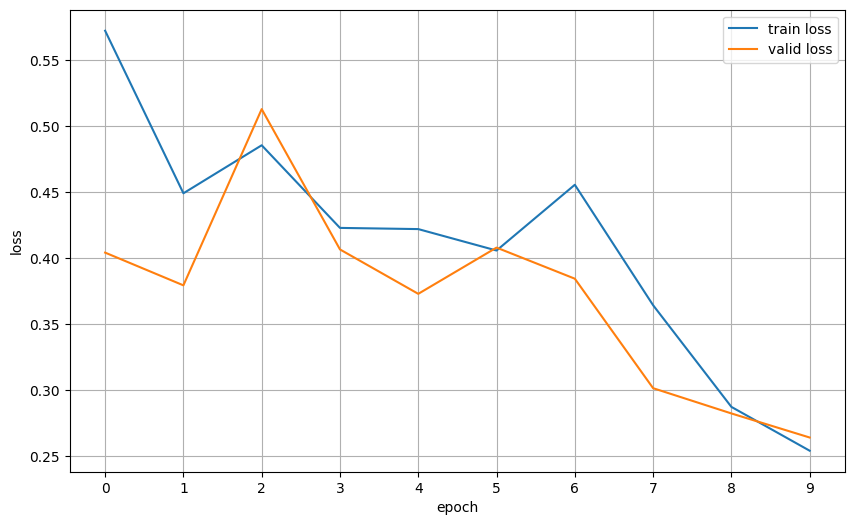

In [56]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

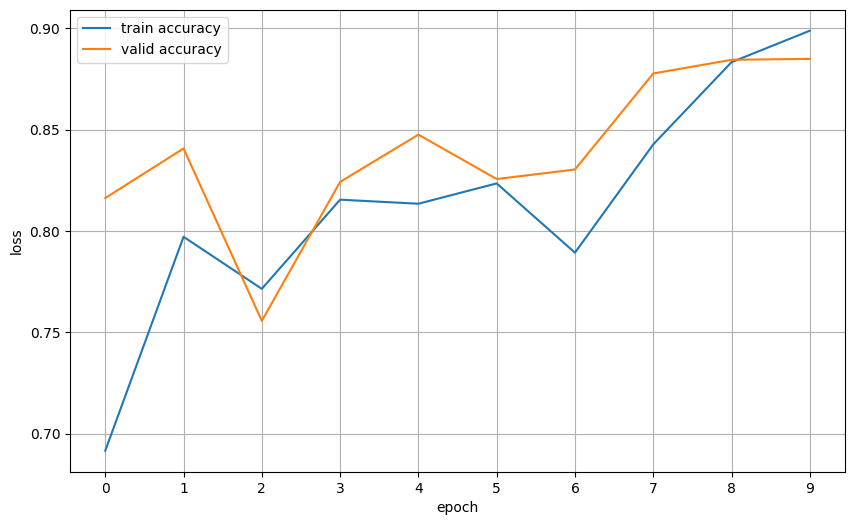

In [57]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [58]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [59]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.292, test_acc: 0.876


In [60]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [61]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9896615743637085)

In [62]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9805727005004883)

In [63]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.8192335963249207)

In [64]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9564829468727112)

In [85]:
text = "Despite the large investments into the production of this movie, I must say it kinda fell short of my expectations"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.6870540976524353)

In [91]:
text = "The only part of the movie i liked was the beginning"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5615984797477722)